In [1]:
from transformers import pipeline, set_seed

### Hugging face tutorial

In [2]:
generator = pipeline('text-generation', model='gpt2')

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
generator('tripping on hallucinogenics', max_length=30, pad_token_id=50256, num_return_sequences=5)

[{'generated_text': 'tripping on hallucinogenics or other drugs in that area, however, is not uncommon. I would assume that they all have some other substance'},
 {'generated_text': 'tripping on hallucinogenics\n\nThe next morning, the government found out that the drugs were on the radar "probably as soon as a'},
 {'generated_text': 'tripping on hallucinogenics is a common occurrence. The drug is produced and sold in a laboratory by some companies, and has a unique effect'},
 {'generated_text': 'tripping on hallucinogenics. He was found to lack the capacity to take vitamins when he took his own medication, and was only known to'},
 {'generated_text': 'tripping on hallucinogenics, or simply hallucinogen-inducing drugs. There are a number of different versions of hallucinogens which can'}]

### fastai experiment

In [9]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [7]:
text = 'Tripping on hallucinogenics'
encoded_input = tokenizer.encode(text)
encoded_input

[14824, 2105, 319, 23251, 259, 6644, 873]

In [8]:
tokenizer.decode(encoded_input)

'Tripping on hallucinogenics'

In [10]:
t1 = torch.LongTensor(encoded_input)[None]
preds = model.generate(t1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [11]:
preds

tensor([[14824,  2105,   319, 23251,   259,  6644,   873,   318,   257,  2219,
          3357,   287,   262,  1578,  1829,    13,   198,   198,   464,  2563]])

In [12]:
tokenizer.decode(preds[0])

'Tripping on hallucinogenics is a common practice in the United States.\n\nThe drug'

### integrate with fastai

In [13]:
from fastai.text.all import *

In [40]:
def get_text_data():
    pth = Path('../data')
    files = get_text_files(pth).sorted()
    txt = [f.open(encoding='gb18030').read() for f in files]
    return txt

In [138]:
txt = get_text_data()

In [34]:
pth = Path('../data')/'harry potter4.txt'
pth

Path('../data/harry potter4.txt')

In [44]:
tokenizer.tokenize(txt[0][:100]),txt[0][:100]

(['--------------------',
  '---',
  'ĠPage',
  'Ġ1',
  '--------------------',
  '---',
  'ĊĊ',
  'Ġ',
  'Ġ',
  'ĠThe',
  'ĠCome',
  'plete',
  'ĠHarry',
  'ĠPotter',
  'ĠCollection',
  'Ġ',
  'Ġ',
  'Ċ',
  'Ġ',
  'Ċ'],
 '----------------------- Page 1-----------------------\n\n   The Comeplete Harry Potter Collection  \n \n')

In [49]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(
            self.tokenizer.convert_tokens_to_ids(toks)
        )
    
    def decodes(self,x):
        return TitledStr(self.tokenizer.decode(x.cpu()))

- in encodes we don't use the tokenizer.encode method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in decodes we return a TitledStr object and not just a plain string. That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods.

In [46]:
toks = tokenizer.tokenize(txt[0][:100])
t1 = tensor(tokenizer.convert_tokens_to_ids(toks))
t1

tensor([19351,  6329,  7873,   352, 19351,  6329,   628,   220,   220,   383,
         7911,  6677,  5850, 14179, 12251,   220,   220,   198,   220,   198])

In [76]:
len(txt)

7

### fastai data

In [50]:
path = untar_data(URLs.WIKITEXT_TINY)

In [52]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [64]:
splits = [[0,1,2,3,4],[5,6]]
tls = TfmdLists(txt, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [78]:
len(tls.train),len(tls.valid)

(5, 2)

In [80]:
len(tls.train[0])

149901

In [81]:
bs = 4
sl = 256
dls = tls.dataloaders(bs=4, seq_len=sl)

In [83]:
x,y = first(dls.train)

In [85]:
x.shape,y.shape

(torch.Size([4, 256]), torch.Size([4, 256]))

In [ ]:
dls.show_batch(max_n=2)

In [88]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

In [91]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[accuracy, Perplexity()]).to_fp16()

In [92]:
learn.validate()

(#3) [3.6438446044921875,0.3942023813724518,38.23856735229492]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

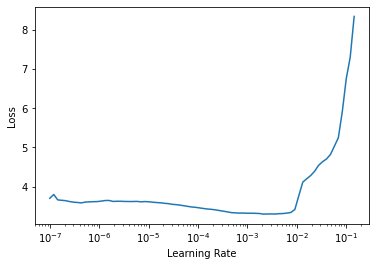

In [93]:
learn.lr_find()

In [94]:
learn.fit_one_cycle(1, 3e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.624687,4.227454,0.371931,68.542511,53:41


In [155]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.443017,4.227674,0.379385,68.557587,1:15:12


In [97]:
x[0][200:300]

LMTensorText([ 3114,   329,  1223,   220,   220,   198,  5562,   561,  1037,   683,
         3551,   465, 14268,    11,   366,    54,  2007, 21460,   287,   262,
         6675, 20283,   220,   220,   198, 19085,  1601,  8920, 13248,   306,
         6252,  1203,  2112,   526,   220,   220,   198,   220,   198,   464,
          627,   359, 24487,   379,   262,  1353,   286,   257,  1884,    12,
        11534,  7322,    13,  5850,   350,  7474], device='cuda:0')

In [99]:
tokenizer.decode(x[0][200:300])

' looked for something  \nthat would help him write his essay, "Witch Burning in the Fourteenth  \nCentury Was Completely Pointless discuss."  \n \nThe quill paused at the top of a likely-looking paragraph. Harry Pushed'

In [156]:
txt = 'Harry, what is wrong with you?'
ids = tokenizer.encode(txt)
inp = tensor(ids)[None].cuda()

In [157]:
preds = learn.model.generate(inp, max_length=100)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [158]:
tokenizer.decode(preds[0].cpu())

"Harry, what is wrong with you?''I'm not going to tell you,' said Harry, 'I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I'm not going to tell you what's wrong with you. I"

In [131]:
preds[0][200:]

tensor([11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 11536,    11,
          262,  3801, 11536,    11,   262,  3801, 11536,    11,   262,  3801,
        11536,    11,   262,  3801, 11536,    11,   262,  3801, 

In [141]:
num_t = 0
for t in txt:
    num_t += len(t)
    print(len(t))

486827
544314
675372
1240897
1499118
1209375
1377391


In [142]:
num_t

7033294